# Messy File - Finding Dates

## 1) Objective
Often, people who don't have a data science background store information in a so-called "messy" file structure. The term "messy" here **does not refer to untidy or faulty data**. These files are ususally **well readable for humans**, but **not for machines** - which makes automation challenging. "Messy" here refers to **inconsistencies** in notation, standards and order.<br> 
For example you want to track certain medication treatments for a certain disease over many decades of medical records.<br> 

- The name of the drug or **drug manufacturer migh have changed** over time, even though it has been the same drug.
- Some doctors might have used **abbreviations** (which can differ),
- some might have used a **medical drug ID** (which can also differ) and the
- **input mask of the GUI** the doctors worked with also changed over the decades
- such that the **same information might have been stored differently**.
- And finally, sometimes **naming and location** of the data itself is **unclear**.

All these things have to be taken into account. Below is an example of a messy file with inconsitent date strings and sensor identification:

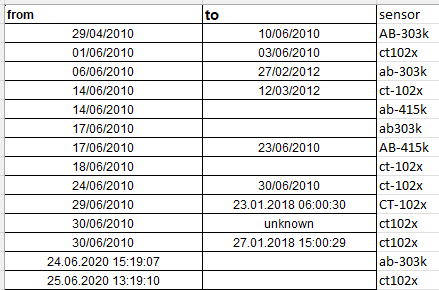

Even the date itself is not labelled as such!

<br>

## 2) Preparation

For the following workflow, we want to **extract the dates** and turn them **into numerical values**, say for plotting and subsequent timeseries analysis. But we only know the name of the file and that it contains dates somewhere. We don't know<br>
- **where the file is** stored,
- **where the date strings are** stored in the file,
- **if the date columns are labelled** as such,
- **which date format** had been used (maybe several?) and,
- if there are **gaps in the records**.

Therefore, we first need to write a few subroutines to deal with these issues.<br>
We first load the standard libraries:

In [ ]:
import numpy as np
import pandas as pd

Next, we load libraries that will help us for the subsequent tasks:

In [ ]:
import os                           # for navigating through folders/harddiscs etc
from astropy.time import Time       # for turning time string into numerical value, say MJD
from dateutil.parser import parse   # parsing

<br>

**2.1) Find the file!**

We build a function that searches for a file within a certain path variable, which can be even a network of computers, and returns the location.

In [ ]:
def FindMyFile(filename: str, ServerHardDiscPath: str = r"c:\Users\MMH_user\Desktop") -> str:
    """
    finds file of name "filename" anywhere in "ServerHardDiscPath" and returns complete path
    """
    for r,d,f in os.walk(ServerHardDiscPath):
        for files in f:
             if files == filename: #for example "MessyFile.xlsx"
                 file_name_and_path =  os.path.join(r,files)
                 return file_name_and_path

Let's find the messy file:

In [ ]:
Data = pd.read_excel(FindMyFile('MessyFile.xlsx'))
print(Data.head)

In [ ]:
print(Data.sample(10)) # random sampling of 10 entires

<br>

**2.2) Parsing Date Columns** 

We see that the date columns are not labelled as such, so that **we can't run any regex search**. The labels "from" and "to" are very unspecific and that might apply to the other files too. Thus, the only way to find a date is to look at the date string.<br>
We can use 'parse' and see how well that goes:

In [ ]:
parse(str(Data['from'][0]))

In [ ]:
print(Data['from'][0],  parse(str(Data['from'][0])))
print(Data['from'][23], parse(str(Data['from'][23])))
print(Data['from'][27], parse(str(Data['from'][27])))
print(Data['from'][29], parse(str(Data['from'][29])))

Note: we would need to check if the date string is US or international format first! For setting the date string to a certain date order format (which is usually known) one can use the command *"timestamp.strftime('%Y-%m-%d')"* for the international format *YYYY-MM-DD*.

<br>

**2.3) Finding Date Columns**

Since we know now that 'parse' works with any common date string, we can use it in order to detect a date column. 

In [ ]:
def IsDate(val: str):
    """
    checks if string can be interpreted as date string of any common format such as 17/07/2017 or 17-07-2017 etc
    """
    try:
        if pd.isna(val):
            return False
        parse(str(val)) #checks if common date format
        return True
    except Exception:
        return False

In [ ]:
print(IsDate('17/07/2017'), IsDate('17-07-2017'), IsDate('47/47/2017'), IsDate('3017'), IsDate('34435'))

In [ ]:
def DetectDateColumns(df, Nsample: int = 20, Tolerance: float = 0.7):
    """
    returns columns that could be date columns
    """
    date_cols = []
    for col in df.columns:
        
        sample_vals = df[col].dropna().astype(str)
        
        if len(sample_vals) == 0:
            continue
        
        sample_vals = sample_vals.sample(min(Nsample, len(sample_vals))) # samples a column (Nsample rows)
        
        if sample_vals.apply(IsDate).mean() > Tolerance:                 # applies "IsDate" in order to check for date strings and interprets
                                                                         # column as date column if certain fraction of rows with confirmed date strings
                                                                         # were found               
            date_cols.append(col)
            
    return date_cols

Now we can search for the date columns:

In [ ]:
DateCols = DetectDateColumns(Data, Tolerance = 0.5)
print(DateCols)

<br>

## 3) Extracting and Converting Date Strings

Finally, we need to extract the date strings and convert them to a numerical value. There are different standards how to do that but they all have in common that the seconds are counted continiously from a reference day on. For example, one refrence is the Modified Julian Day or MJD, which is Jan 1st 4713 B.C. midnight minus 2400000.5 days. For example, Jan 30th 2000 is MJD 51573.<br>
Fortunately, python has the corresponding library.

In [ ]:
def DateStrToMJD(df):
    """
    function converts date string to MJD
    """
    
    MJD = [None]*len(df)
    for i, d in enumerate(df):
        try:
            mjd    = Time(parse(str(d)), format = 'datetime').mjd
            MJD[i] = mjd
        except Exception:
            MJD[i] = np.nan # if not a date string (gap, random string etc) --> return nan
    return MJD

Therefore, the entire workflow now reads:

In [ ]:
def ReturnDatesFromFile(filename: str = 'MessyFile.xlsx', ServerHardDiscPath: str = r"c:\Users\MMH_user\Desktop",\
                        Nsample:  int = 20, Tolerance: float = 0.7):
    
    Data     = pd.read_excel(FindMyFile(filename, ServerHardDiscPath)) # finds location of file
    DateCols = DetectDateColumns(Data, Nsample, Tolerance)             # finds date columns by searching for common date formats
    
    Dates    = [None]*len(DateCols)

    for i, d in enumerate(DateCols):
        Dates[i] = DateStrToMJD(Data[d])                               # converts date string to numerical (here: MJD)
        
    return np.array(Dates).transpose()

In [ ]:
NumDates = ReturnDatesFromFile()

In [ ]:
print(NumDates[:25,:])